# 1. 数据处理

## 1.1 导入一些必要的库

In [237]:
import pandas as pd
import numpy as np
import scipy.stats as stats # 统计模块
import scipy
from matplotlib import style
import matplotlib.pyplot as plt  # 画图模块
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties # 作图中文
from pylab import mpl
from matplotlib.ticker import AutoMinorLocator
import statsmodels.formula.api as smf  # OLS regression
import pyreadr # read RDS file
from statsmodels.iolib.summary2 import summary_col
#设置列不限制数量
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows',None)

#输出矢量图 渲染矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell # jupyter运行输出的模块
#显示每一个运行结果
InteractiveShell.ast_node_interactivity = 'all'

#设置行不限制数量
#pd.set_option('display.max_rows',None)

#设置列不限制数量
pd.set_option('display.max_columns', None)

## 1.2 开始处理数据

接下来我要整理市场阅读回报率和无风险利率的数据。
* 只留下市场类型为21的。
* 按照日期把无风险利率进行合并，用收益率减去无风险利率。
* 导出为Excess_Return.xlsx

In [238]:

# 读取数据（跳过前3行非数据行，中文标题在第2行）
df = pd.read_excel("datasets/TRD_Cnmont.xlsx", header=1, skiprows=[2])

# 筛选市场类型为21的行
df_filtered = df[df["市场类型"] == 21]

# 直接提取原始月份（无需格式化）
df_filtered["date"] = df_filtered["交易月份"]

# 选择并重命名列
result = df_filtered[["date", "考虑现金红利再投资的综合月市场回报率(流通市值加权平均法)"]].rename(
    columns={"考虑现金红利再投资的综合月市场回报率(流通市值加权平均法)": "return"}
)

# 保存到 datasets 文件夹，文件名为 return21_month.xlsx
result.to_excel("datasets/return_month21.xlsx", index=False)

c:\Users\thinkpad\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [239]:
# -------------------------------------------------------------------
# 1. 读取月度回报率数据
# -------------------------------------------------------------------
df_return = pd.read_excel("datasets/return_month21.xlsx")

# -------------------------------------------------------------------
# 2. 处理无风险利率数据（修正百分比单位问题）
# -------------------------------------------------------------------
# 跳过前3行非数据行，手动指定列名
df_nrrate = pd.read_excel(
    "datasets/TRD_Nrrate.xlsx",
    skiprows=3,
    names=["Nrr1", "Clsdt", "Nrrmtdt"]  # 原始列名：Nrr1, 统计日期, 月度化无风险利率(%)
)

# 关键修正：将百分比转换为小数（例如 0.1856% → 0.001856）
df_nrrate["Nrrmtdt"] = df_nrrate["Nrrmtdt"] / 100

# 提取月份并去重
df_nrrate["month"] = pd.to_datetime(df_nrrate["Clsdt"]).dt.to_period("M").astype(str)
df_nrrate = df_nrrate.groupby("month")["Nrrmtdt"].first().reset_index()
df_nrrate = df_nrrate.rename(columns={"Nrrmtdt": "risk_free_rate"})

# -------------------------------------------------------------------
# 3. 合并数据并计算超额收益率 & 多期累计超额收益率
# -------------------------------------------------------------------
merged = pd.merge(
    df_return.rename(columns={"date": "month"}),
    df_nrrate,
    on="month",
    how="left"
)

# 计算当月超额收益率（已是小数）
merged["excess_return"] = merged["return"] - merged["risk_free_rate"]

# 计算 2、3、4、5 个月的累计超额收益率（复利方式）
for n in [2, 3, 4, 5]:
    merged[f"excess_cum_{n}m"] = (
        (1 + merged["excess_return"])
        .rolling(window=n)
        .apply(np.prod, raw=True)  # 计算滚动窗口内 (1+excess_return) 的乘积
        - 1
    )

# -------------------------------------------------------------------
# 4. 保存结果（保留所有关键列）
# 先选你想要输出的列（这里还保留 month）
out_cols = ["month", "return", "risk_free_rate",'excess_return'] + [f"excess_cum_{n}m" for n in [2,3,4,5]]
# 选完再 rename
merged[out_cols] \
    .rename(columns={"month": "date"}) \
    .to_excel("datasets/excess_return.xlsx", index=False)


In [240]:
# 本单元格是导入数据的代码
data = pd.read_excel('datasets/excess_return.xlsx') # 这一句是导入CSV文件的命令
data # 让我看看数据是什么样子

,date,return,risk_free_rate,excess_return,excess_cum_2m,excess_cum_3m,excess_cum_4m,excess_cum_5m
0,2000-01,0.160838,0.001856,0.158982,NaN,NaN,NaN,NaN
1,2000-02,0.122024,0.001856,0.120168,0.298255,NaN,NaN,NaN
2,2000-03,0.055926,0.001856,0.054070,0.180735,0.368451,NaN,NaN
3,2000-04,0.013014,0.001856,0.011158,0.065831,0.193910,0.383720,NaN
4,2000-05,0.027691,0.001856,0.025835,0.037281,0.093367,0.224755,0.419469
...,...,...,...,...,...,...,...,...
295,2024-08,-0.031468,0.001118,-0.032586,-0.033205,-0.072553,-0.080502,-0.066228
296,2024-09,0.195992,0.001118,0.194874,0.155938,0.155198,0.108183,0.098684
297,2024-10,-0.003409,0.001118,-0.004527,0.189465,0.150705,0.149968,0.103166
298,2024-11,0.009724,0.001118,0.008606,0.004040,0.199701,0.160608,0.159865


## 1.3 了解一下变量格式

In [241]:
type(data)

pandas.core.frame.DataFrame

## 1.4 设置时间索引

In [242]:
data = data.sort_values(by=['date'],ascending=True)
data.set_index('date', inplace = True)
data


,return,risk_free_rate,excess_return,excess_cum_2m,excess_cum_3m,excess_cum_4m,excess_cum_5m
date,,,,,,,
2000-01,0.160838,0.001856,0.158982,NaN,NaN,NaN,NaN
2000-02,0.122024,0.001856,0.120168,0.298255,NaN,NaN,NaN
2000-03,0.055926,0.001856,0.054070,0.180735,0.368451,NaN,NaN
2000-04,0.013014,0.001856,0.011158,0.065831,0.193910,0.383720,NaN
2000-05,0.027691,0.001856,0.025835,0.037281,0.093367,0.224755,0.419469
...,...,...,...,...,...,...,...
2024-08,-0.031468,0.001118,-0.032586,-0.033205,-0.072553,-0.080502,-0.066228
2024-09,0.195992,0.001118,0.194874,0.155938,0.155198,0.108183,0.098684
2024-10,-0.003409,0.001118,-0.004527,0.189465,0.150705,0.149968,0.103166


# 2. 数据可视化

c:\Users\thinkpad\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
c:\Users\thinkpad\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(730120.0, 739221.0)

Text(0,0.5,'Excess Return')

Text(0.5,0,'Year')

Text(0.5,1,"China's Market excess return(2001-2024)")

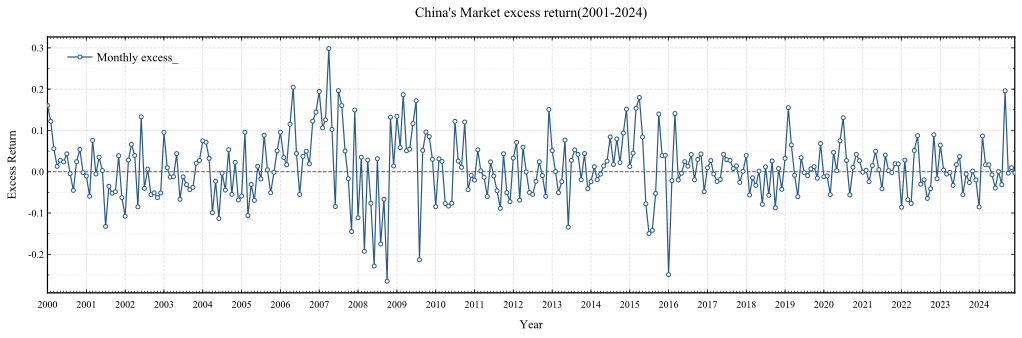

In [243]:
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.unicode_minus': False  # 解决负号显示问题
})

# 转换索引
data.index = pd.to_datetime(data.index, format='%Y-%m')

# 创建画布
fig, ax = plt.subplots(figsize=(15, 5.5))

# 提升画质
fig.set_dpi(300)
plt.rcParams['pdf.fonttype'] = 42  # 确保PDF文本可编辑

# 数据范围处理
valid_data = data.loc['2000-01':'2024-12']

# 核心绘画
ax.plot(
    valid_data.index.to_pydatetime(),  # 确保时间格式兼容
    valid_data['return'],
    color='#2b5989',  # 深蓝色调
    marker='o',
    markersize=4,
    linewidth=1.2,
    markerfacecolor='w',  # 空心标记
    markeredgewidth=1,
    zorder=3,
    label='Monthly excess_'
)

# 零轴强化
ax.axhline(
    0,
    color='#666666',
    linestyle='--',
    linewidth=1,
    zorder=2
)

# 日期轴精细化处理
ax.set_xlim(pd.to_datetime(['2000-01', '2024-12']))

# 主次刻度设置
ax.xaxis.set_major_locator(mdates.YearLocator())  # 年度主刻度
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=range(1,13)))  # 月度次刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 年份格式

# 网格系统
ax.grid(which='major', axis='both', ls='--', lw=0.8, alpha=0.6)
ax.grid(which='minor', axis='y', ls=':', alpha=0.4)

# 标签优化
ax.set_ylabel('Excess Return', labelpad=10)
ax.set_xlabel('Year', labelpad=10)
ax.tick_params(axis='x', which='major', pad=8)

# 边距调整
plt.margins(x=0.003)

# 坐标轴比例美化
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.tick_params(which='both', direction='in', top=True, right=True)

# 文体强化
ax.set_title("China's Market excess return(2001-2024)", 
            fontsize=14, 
            pad=20,
            fontweight='semibold')

# 图例定位
ax.legend(
    frameon=False,
    loc='upper left',
    bbox_to_anchor=(0.01, 0.98),
    handletextpad=0.4
)

# 紧凑布局
fig.tight_layout(pad=3)

# 最终输出
fig.savefig('Premium_TS.pdf', 
           bbox_inches='tight', 
           dpi=900,
           metadata={'CreationDate': None})  # 去除时间戳

plt.show()


# 3. 描述性统计

## 3.1 均值、标准差最小最大值、统计量等

In [244]:
np.mean(data['2000-01':'2024-12']['excess_return']) # 计算平均值

0.006677846666666667

In [245]:
data['2000-01':'2024-12']['excess_return'].describe()

count    300.000000
mean       0.006678
std        0.075764
min       -0.268524
25%       -0.039811
50%        0.006034
75%        0.041538
max        0.296042
Name: excess_return, dtype: float64

## 3.2 偏度与峰度

In [246]:
data['2000-01':'2024-12']['excess_return'].skew()
data['2000-01':'2024-12']['excess_return'].kurt()

0.00742119499349763

1.7091985775604397

## 3.3 直方图与标准正态分布对比

<Figure size 3000x1500 with 0 Axes>

(array([0.59042403, 0.        , 0.        , 0.59042403, 0.        ,
        0.        , 0.59042403, 0.        , 0.        , 0.59042403,
        0.        , 0.        , 0.59042403, 0.        , 0.        ,
        0.59042403, 0.        , 0.        , 0.        , 0.        ,
        0.59042403, 0.59042403, 0.59042403, 1.18084806, 0.        ,
        0.        , 0.        , 1.18084806, 1.18084806, 0.59042403,
        0.        , 1.18084806, 3.54254418, 3.54254418, 1.77127209,
        2.95212015, 4.13296822, 5.90424031, 5.90424031, 3.54254418,
        3.54254418, 2.95212015, 3.54254418, 6.49466434, 4.72339225,
        5.90424031, 9.44678449, 7.08508837, 4.72339225, 8.85636046,
        5.31381628, 7.08508837, 8.85636046, 4.72339225, 8.26593643,
        2.95212015, 7.08508837, 1.77127209, 1.77127209, 1.77127209,
        2.36169612, 0.59042403, 3.54254418, 1.18084806, 2.36169612,
        1.18084806, 0.        , 1.18084806, 2.36169612, 0.59042403,
        1.77127209, 0.59042403, 1.77127209, 1.18

Text(0.5,1,'Distribution of Excess Market Returns\n(January 2000 - December 2024)')

Text(0.5,0,'Excess Return')

Text(0,0.5,'Probability Density')

(array([-0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 <a list of 8 Text xticklabel objects>)

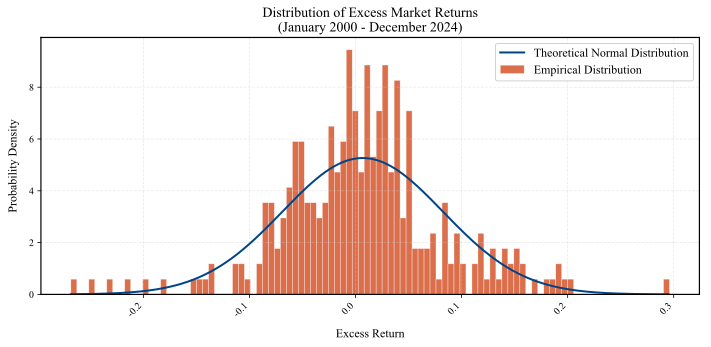

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置学术图表样式
plt.rcParams.update({
    'font.family': 'Times New Roman',  # 学术标准字体
    'font.size': 12,                   # 基础字号
    'axes.labelsize': 12,              # 坐标轴标签字号
    'axes.titlesize': 14,              # 标题字号
    'xtick.labelsize': 10,             # X轴刻度字号
    'ytick.labelsize': 10,             # Y轴刻度字号
    'axes.linewidth': 1.2,             # 坐标轴线宽
    'grid.color': '0.8',               # 网格线颜色
    'grid.linestyle': '--',            # 网格线样式
    'grid.alpha': 0.4                  # 网格线透明度
})

# [保留原有的数据加载和处理代码]
# 2. 提取目标时间段
subset = data['2000-01':'2024-12']

# 3. 计算统计量
retmean = subset['excess_return'].mean()
retstd = subset['excess_return'].std()
retmin = subset['excess_return'].min()
retmax = subset['excess_return'].max()

# 4. 定义正态分布函数
def normfun(x, mu, sigma):
    pdf = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
    return pdf

x = np.arange(retmin, retmax, 0.001)
y = normfun(x, retmean, retstd)

# 5-6. 绘制专业学术图表
plt.figure(figsize=(10, 5), dpi=300)  # 提高分辨率
plt.plot(x, y, color='#004488', lw=2, label='Theoretical Normal Distribution')  # 使用学术蓝色
plt.hist(subset['excess_return'], 
         bins=100, 
         density=True, 
         color='#CC3300', 
         alpha=0.7, 
         edgecolor='w', 
         linewidth=0.5,
         label='Empirical Distribution')

# 增强图表可读性元素
plt.title('Distribution of Excess Market Returns\n(January 2000 - December 2024)')
plt.xlabel('Excess Return', labelpad=10)
plt.ylabel('Probability Density', labelpad=10)
plt.xticks(rotation=45, ha='right', fontsize=10)  # 优化刻度标签显示
plt.grid(True, which='both', axis='both')
plt.legend(frameon=True, framealpha=0.9, loc='upper right')

# 调整边界空白
plt.tight_layout()
plt.show()


# 4. 预测

## 4.1 模型

### 4.1.1 传统理论
根据Fama（1970）提出的有效市场假说（Efficient Market Hypothesis, EMH），在弱式有效市场条件下，资产价格已充分反映所有历史公开信息（包括价格序列、交易量等）。然而行为金融学理论指出，由于投资者存在系统性认知偏差与非理性决策（如羊群效应、过度反应等），资产价格可能出现持续性的动量效应（Momentum Effect）。De Long et al. (1990) 的噪声交易者模型表明，非理性投资者的群体行为会导致价格对基本面价值的持续性偏离。这表现为股票价格今日上涨明日还是上涨，对应的收益率持续为正。具体来讲，今天收益率为正明天大概率为正，反之今天收益率为负反之也为负。
### 4.1.2 模型构建
$$
r_{t}=\alpha+\beta r_{t-1}+\varepsilon_{t+1}
$$
其中：
* $r_t$表示第t期的考虑现金红利再投资的综合月市场超额回报率（流通市值加权平均法）
* $\varepsilon$为独立同分布的随机扰动项，满足$E(ε_t) = 0$，$Var(ε_t) = σ²$。
### 4.1.3 假设：
* H1：$\beta > 0$

* H2：$\beta > 0$随着时间t增加，系数也不再显著。（动量效应减弱）

## 4.2 OLS回归结果

In [248]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# 1. 读取数据
merged = pd.read_excel("datasets/excess_return.xlsx")

# 2. 生成滞后变量
merged['excess_return_lag1'] = merged['excess_return'].shift(-1)
merged['excess_cum_2m_lag1'] = merged['excess_cum_2m'].shift(-1)
merged['excess_cum_3m_lag2'] = merged['excess_cum_3m'].shift(-2)
merged['excess_cum_4m_lag3'] = merged['excess_cum_4m'].shift(-3)
merged['excess_cum_5m_lag4'] = merged['excess_cum_5m'].shift(-4)
merged

# 3. 进行 OLS 回归（普通标准误）
models = []
names = ['L1.excess_return', 'L1.excess_cum_2m', 'L2.excess_cum_3m', 'L3.excess_cum_4m', 'L4.excess_cum_5m']
y_vars = ['excess_return_lag1', 'excess_cum_2m_lag1', 'excess_cum_3m_lag2', 'excess_cum_4m_lag3', 'excess_cum_5m_lag4']

for y in y_vars:
    df_reg = merged[['excess_return', y]].dropna()
    X = sm.add_constant(df_reg['excess_return'])   # 加常数项
    y = df_reg[y]
    
    model = sm.OLS(y, X).fit()  # 普通OLS fit，不指定cov_type，就是普通标准误
    models.append(model)

# 4. 整理成一张表
info = {
    'N': lambda x: f"{int(x.nobs)}",
    'R2': lambda x: f"{x.rsquared:.3f}",
    'Adj R2': lambda x: f"{x.rsquared_adj:.3f}",
}

table = summary_col(
    models,
    stars=True,
    model_names=names,
    float_format='%0.3f',
    info_dict=info,
    regressor_order=['const', 'excess_return']
)

print(table)


,date,return,risk_free_rate,excess_return,excess_cum_2m,excess_cum_3m,excess_cum_4m,excess_cum_5m,excess_return_lag1,excess_cum_2m_lag1,excess_cum_3m_lag2,excess_cum_4m_lag3,excess_cum_5m_lag4
0,2000-01,0.160838,0.001856,0.158982,NaN,NaN,NaN,NaN,0.120168,0.298255,0.368451,0.383720,0.419469
1,2000-02,0.122024,0.001856,0.120168,0.298255,NaN,NaN,NaN,0.054070,0.180735,0.193910,0.224755,0.251534
2,2000-03,0.055926,0.001856,0.054070,0.180735,0.368451,NaN,NaN,0.011158,0.065831,0.093367,0.117274,0.163516
3,2000-04,0.013014,0.001856,0.011158,0.065831,0.193910,0.383720,NaN,0.025835,0.037281,0.059961,0.103832,0.096605
4,2000-05,0.027691,0.001856,0.025835,0.037281,0.093367,0.224755,0.419469,0.021865,0.048265,0.091652,0.084504,0.033448
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024-08,-0.031468,0.001118,-0.032586,-0.033205,-0.072553,-0.080502,-0.066228,0.194874,0.155938,0.150705,0.160608,0.156201
296,2024-09,0.195992,0.001118,0.194874,0.155938,0.155198,0.108183,0.098684,-0.004527,0.189465,0.199701,0.195146,NaN
297,2024-10,-0.003409,0.001118,-0.004527,0.189465,0.150705,0.149968,0.103166,0.008606,0.004040,0.000228,NaN,NaN
298,2024-11,0.009724,0.001118,0.008606,0.004040,0.199701,0.160608,0.159865,-0.003797,0.004776,NaN,NaN,NaN



              L1.excess_return L1.excess_cum_2m L2.excess_cum_3m L3.excess_cum_4m L4.excess_cum_5m
--------------------------------------------------------------------------------------------------
const         0.005            0.006            0.012*           0.019**          0.027**         
              (0.004)          (0.004)          (0.007)          (0.009)          (0.011)         
excess_return 0.145**          1.177***         1.311***         1.395***         1.655***        
              (0.057)          (0.058)          (0.090)          (0.119)          (0.147)         
N             299              299              298              297              296             
R2            0.021            0.579            0.419            0.318            0.300           
Adj R2        0.018            0.577            0.417            0.315            0.297           
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## 4.3 输出到word

In [249]:
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT

# ========== 1. 假设你已经有 models 列表 ==========
# models = [model_lag1, model_lag2, model_lag3]

# ========== 2. 打星号函数 ==========
def get_stars(p):
    if p < 0.01: return '***'
    if p < 0.05: return '**'
    if p < 0.10: return '*'
    return ''

# ========== 3. 拼接表格内容 ==========
# 表头：第一列空白，然后依次是三个机Lag
headers     = ['', 'Lag1',  'Lag2', 'Lag3','Lag4','Lag5','Lag6','Lag7','Lag8','Lag9','Lag10']
predictors  = ['const','L1_excess',
                       'L2_excess',
                         'L3_excess',
                         'L4_excess',
                         'L5_excess',
                         'L6_excess',
                         'L7_excess',
                         'L8_excess',
                         'L9_excess',
                         'L10_excess']

rows = []
# 对每个预测变量，先 coef 行，再 SE 行
for pred in predictors:
    coef_row = [pred]
    se_row   = ['']
    for m in models:
        if pred in m.params:
            c = m.params[pred]
            se = m.bse[pred]
            p = m.pvalues[pred]
            coef_row.append(f"{c:.3f}{get_stars(p)}")
            se_row.append(f"({se:.3f})")
        else:
            coef_row.append('')
            se_row.append('')
    rows.append(coef_row)
    rows.append(se_row)

# 再加 N, R-squared, Adj. R-squared 三行
stats = [
    ('N',           lambda m: int(m.nobs)),
    ('R-squared',   lambda m: m.rsquared),
    ('Adj. R-squared', lambda m: m.rsquared_adj)
]
for name, func in stats:
    line = [name]
    for m in models:
        v = func(m)
        line.append(f"{v:.3f}" if isinstance(v, float) else str(v))
    rows.append(line)

# ========== 4. 写入 Word ==========
doc = Document()
doc.add_heading('滞后回归结果', level=1)

# 创建表格：行数 = 1（表头）+ len(rows)，列数 = len(headers)
table = doc.add_table(rows=1 + len(rows), cols=len(headers), style='Table Grid')
table.alignment = WD_TABLE_ALIGNMENT.CENTER
table.autofit   = False

# 手动设定列宽（单位英寸，可根据你页面大小微调）
col_widths = [1.2,  # 第一列：变量名
              1.0, 1.0, 1.0]  # Lag1, Lag2, Lag3
for idx, w in enumerate(col_widths):
    table.columns[idx].width = Inches(w)

# 填写表头
for i, h in enumerate(headers):
    cell = table.rows[0].cells[i]
    p = cell.paragraphs[0]
    p.text = h
    p.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
    p.runs[0].font.size = Pt(9)

# 填写内容行
for r_idx, row in enumerate(rows, start=1):
    cells = table.rows[r_idx].cells
    for c_idx, txt in enumerate(row):
        p = cells[c_idx].paragraphs[0]
        p.text = txt
        p.alignment = WD_PARAGRAPH_ALIGNMENT.CENTER
        p.runs[0].font.size = Pt(9)

# 保存文件
output_path = 'lagged_regression_summary.docx'
doc.save(output_path)
print(f"已保存到：{output_path}")


已保存到：lagged_regression_summary.docx
